In [1]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import easydict
import pandas as pd
import util
from model import MultiLabelEfficientNet
from torchvision import transforms

In [2]:
util.seed_everything(777)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print('Device : {}'.format(device))

args = easydict.EasyDict({
    "device": device,
    "model": "efficientnet-b6",
    "model_weight": "./save/02011004/model_best.pth.tar", 

    "train_data_file_dir": "./data/dirty_mnist/",
    "test_data_file_dir": "./data/test_dirty_mnist/",

    "train_data_answer_dir": "./data/dirty_mnist_answer.csv",

    "submission_file_dir": "./data/sample_submission.csv",

    "batch_size": 32,
})

assert os.path.isfile(args.model_weight), 'wrong path'
assert os.path.isdir(args.train_data_file_dir), 'wrong path'
assert os.path.isdir(args.test_data_file_dir), 'wrong path'
assert os.path.isfile(args.train_data_answer_dir), 'wrong path'
assert os.path.isfile(args.submission_file_dir), 'wrong path'

model = MultiLabelEfficientNet(args.model)
model.load_state_dict(torch.load(args.model_weight))
print('weight {} is loaded'.format(args.model_weight))

train_data_set = util.DatasetMNIST(
    image_folder=args.train_data_file_dir,
    label=args.train_data_answer_dir,
    transforms=util.mnist_transforms['valid']
    )

train_data_loader = torch.utils.data.DataLoader(
        train_data_set,
        batch_size = 4,
        shuffle = True,
    )

test_data_set = util.DatasetMNIST(
    image_folder=args.test_data_file_dir,
    label=args.submission_file_dir,
    transforms=util.mnist_transforms['test']
)

test_data_loader = torch.utils.data.DataLoader(
        test_data_set,
        batch_size = args.batch_size,
        shuffle = False,
    )

dirty_mnist_answer = pd.read_csv(args.train_data_answer_dir)
iterator = iter(train_data_loader)

unorm = util.UnNormalize(util.mnist_transforms_value['mean'], util.mnist_transforms_value['std'])

Device : cuda:1
Loaded pretrained weights for efficientnet-b6
weight ./save/02011004/model_best.pth.tar is loaded


[]

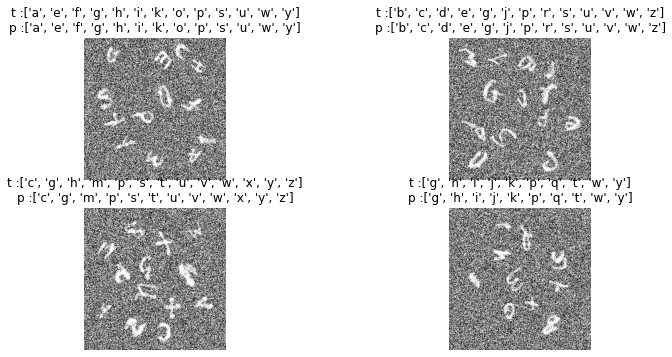

In [7]:
image, label = next(iterator)

image_t = image.float().to(args.device)

model.to(args.device)
model.eval()
pred = model(image_t)

plt.figure(figsize=(12,12))

for idx in range(4):
    plt.subplot(4, 2, idx + 1)

    img = unorm(image[idx])
    img = transforms.ToPILImage()(img).convert("RGB")
    
    true_y = dirty_mnist_answer.columns[1:][label[idx].detach().to('cpu').numpy() > 0].values.tolist()
    pred_y = dirty_mnist_answer.columns[1:][pred[idx].detach().to('cpu').numpy() > 0.5].values.tolist()

    plt.title('t :' + str(true_y) + '\n' + 'p :' + str(pred_y))
    plt.imshow(img)
    plt.axis('off')

plt.plot()

In [6]:
SAVE_PATH = args.model_weight.replace('model_best.pth.tar', '')

submit = pd.read_csv(args.submission_file_dir)

model.eval()
batch_size = args.batch_size
batch_index = 0

for i, (images, targets) in enumerate(tqdm(test_data_loader)):
    images = images.to(args.device)
    # targets = targets.to(args.device)
    outputs = model(images)
    outputs = outputs > 0.5
    batch_index = i * batch_size
    submit.iloc[batch_index:batch_index+batch_size, 1:] = \
        outputs.long().squeeze(0).detach().cpu().numpy()
    
submit.to_csv(os.path.join(SAVE_PATH, args.model_weight.split('/')[2] + '_submission.csv'), index=False)

100%|██████████| 157/157 [00:39<00:00,  3.95it/s]
